In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent
)

2022-11-24 14:22:34.530859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 14:22:34.760147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 14:22:34.760185: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-24 14:22:35.993379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# KuHar Loader
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
    download=False
)

# Print the readme (optional)
# loader.print_readme()

In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 360) (3114,) (246, 360) (246,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3114, 180)
(246, 180)


In [13]:
print(np.max(train_dataset_fft.X))

1199.4899017510002


In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [15]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 180) (3114,) (246, 180) (246,)


# Visualization helper

In [16]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Generic Autoencoders

In [18]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:790.6275, Loss-ae:790.6275, Loss-topo:2.9493
Epoch:2, P:None, Loss:796.9215, Loss-ae:796.9215, Loss-topo:2.9790
Epoch:3, P:None, Loss:789.8844, Loss-ae:789.8844, Loss-topo:2.9131
Epoch:4, P:None, Loss:798.0432, Loss-ae:798.0432, Loss-topo:2.8302
Epoch:5, P:None, Loss:795.0025, Loss-ae:795.0025, Loss-topo:2.8743
Epoch:6, P:None, Loss:798.3552, Loss-ae:798.3552, Loss-topo:2.8398
Epoch:7, P:None, Loss:806.9117, Loss-ae:806.9117, Loss-topo:2.8425
Epoch:8, P:None, Loss:793.3298, Loss-ae:793.3298, Loss-topo:2.6666
Epoch:9, P:None, Loss:806.9053, Loss-ae:806.9053, Loss-topo:2.7442
Epoch:10, P:None, Loss:800.1849, Loss-ae:800.1849, Loss-topo:2.7231
Epoch:11, P:None, Loss:793.9492, Loss-ae:793.9492, Loss-topo:2.5002
Epoch:12, P:None, Loss:799.8401, Loss-ae:799.8401, Loss-topo:2.1605
Epoch:13, P:None, Loss:796.5041, Loss-ae:796.5041, Loss-topo:2.3075
Epoch:14, P:None, Loss:796.4695, Loss-ae:796.4695, Loss-topo:2.3705
Epoch:15, P:None, Loss:793.9083, Loss-ae:793.9083, Loss-t

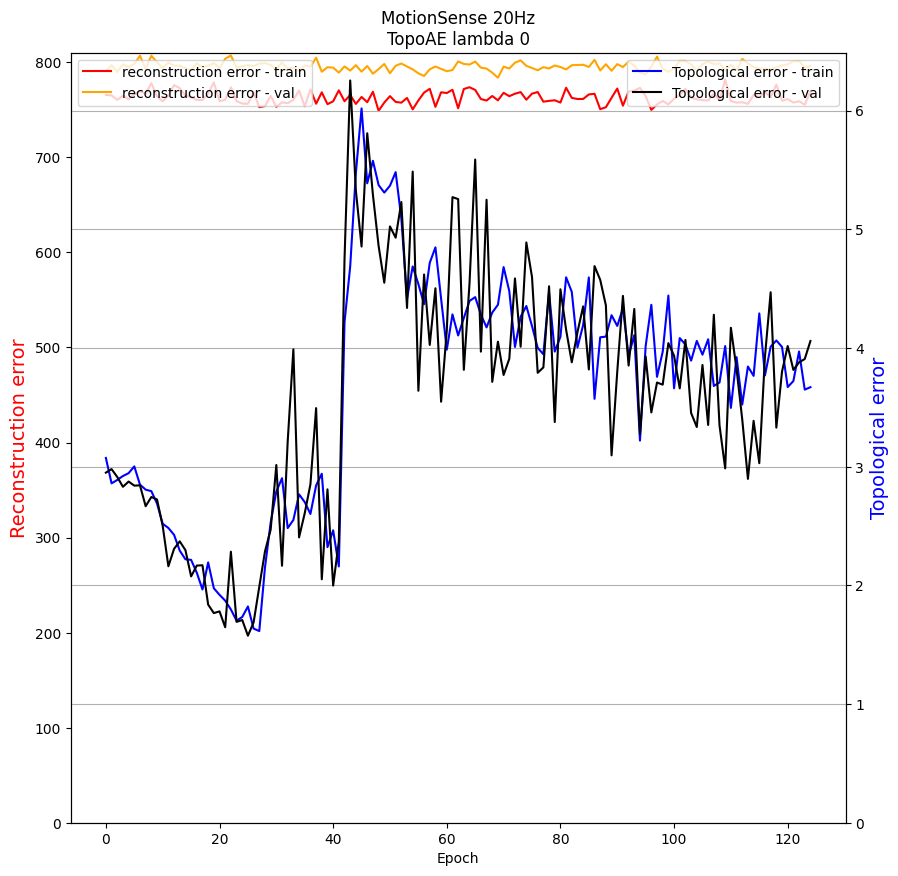

In [19]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [20]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [21]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [22]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.724390243902439,
 'RF-F1': 0.7323621724332634,
 'SVC-ACC': 0.7154471544715447,
 'SVC-F1': 0.7333177554076734,
 'KNN-ACC': 0.6544715447154471,
 'KNN-F1': 0.6644681774922485}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


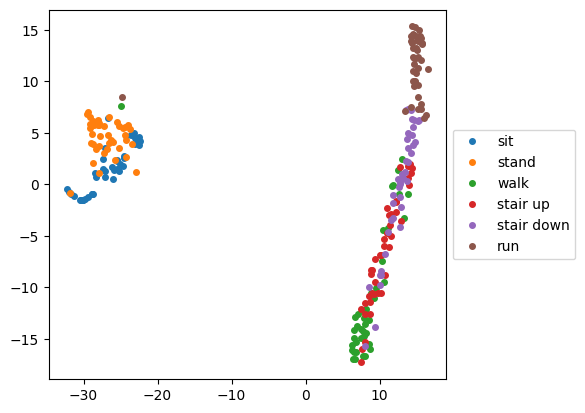

In [23]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [24]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:789.4512, Loss-ae:789.2520, Loss-topo:0.1991
Epoch:2, P:None, Loss:788.6975, Loss-ae:788.6635, Loss-topo:0.0340
Epoch:3, P:None, Loss:799.4207, Loss-ae:799.4101, Loss-topo:0.0106
Epoch:4, P:None, Loss:789.9407, Loss-ae:789.9172, Loss-topo:0.0235
Epoch:5, P:None, Loss:795.6091, Loss-ae:795.5219, Loss-topo:0.0872
Epoch:6, P:None, Loss:800.6838, Loss-ae:800.6665, Loss-topo:0.0173
Epoch:7, P:None, Loss:798.8195, Loss-ae:798.8129, Loss-topo:0.0066
Epoch:8, P:None, Loss:800.0180, Loss-ae:800.0125, Loss-topo:0.0056
Epoch:9, P:None, Loss:798.3367, Loss-ae:798.3300, Loss-topo:0.0066
Epoch:10, P:None, Loss:797.0915, Loss-ae:797.0871, Loss-topo:0.0044
Epoch:11, P:None, Loss:792.0284, Loss-ae:792.0093, Loss-topo:0.0191
Epoch:12, P:None, Loss:802.7728, Loss-ae:802.7648, Loss-topo:0.0079
Epoch:13, P:None, Loss:791.0785, Loss-ae:791.0734, Loss-topo:0.0052
Epoch:14, P:None, Loss:796.6216, Loss-ae:796.6190, Loss-topo:0.0026
Epoch:15, P:None, Loss:789.7586, Loss-ae:789.7528, Loss-t

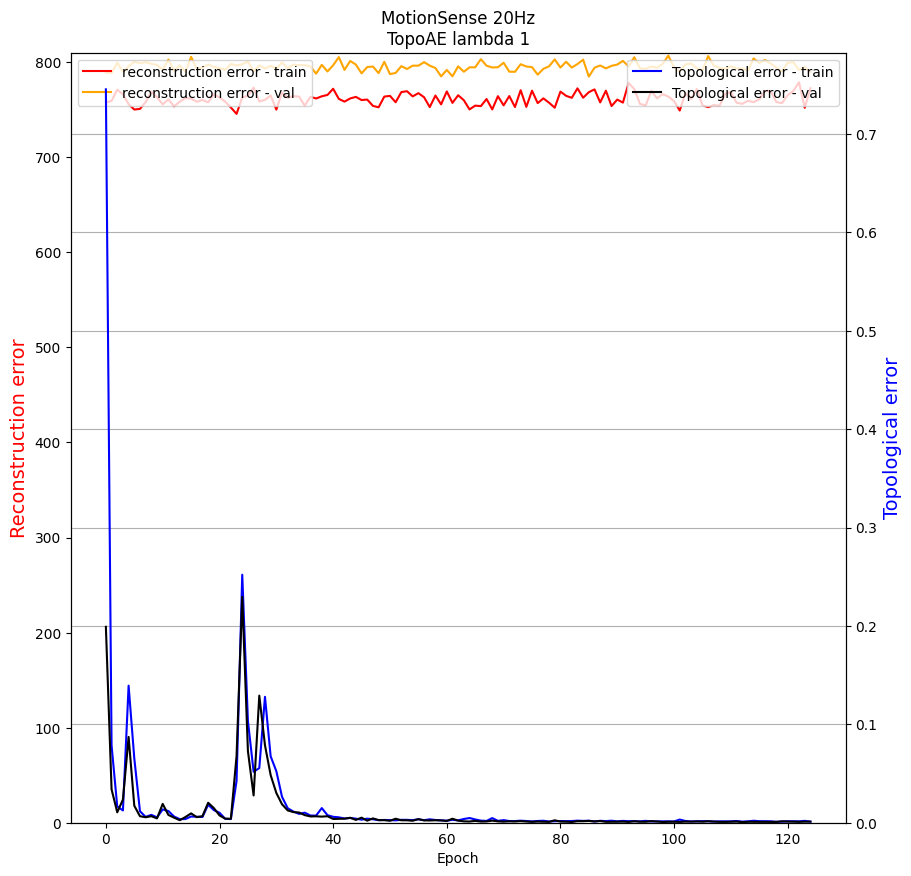

In [25]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [26]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [27]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [28]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6495934959349594,
 'RF-F1': 0.6525543258155421,
 'SVC-ACC': 0.5528455284552846,
 'SVC-F1': 0.5656681085953751,
 'KNN-ACC': 0.556910569105691,
 'KNN-F1': 0.561471227921363}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


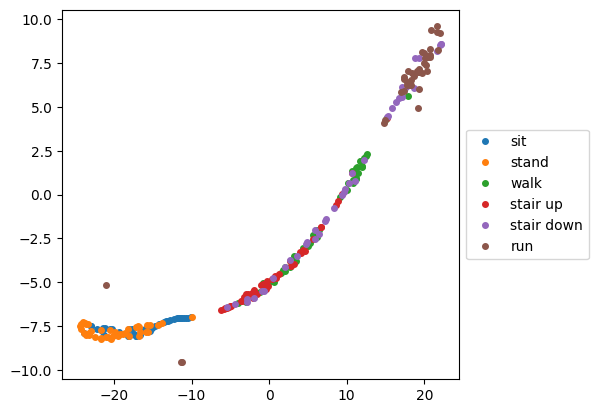

In [29]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [30]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:799.8104, Loss-ae:799.4830, Loss-topo:0.0655
Epoch:2, P:None, Loss:793.8527, Loss-ae:793.8133, Loss-topo:0.0079
Epoch:3, P:None, Loss:798.9150, Loss-ae:798.9028, Loss-topo:0.0024
Epoch:4, P:None, Loss:808.7141, Loss-ae:808.7062, Loss-topo:0.0016
Epoch:5, P:None, Loss:794.3713, Loss-ae:794.3289, Loss-topo:0.0085
Epoch:6, P:None, Loss:797.1482, Loss-ae:797.1384, Loss-topo:0.0020
Epoch:7, P:None, Loss:792.4338, Loss-ae:792.4278, Loss-topo:0.0012
Epoch:8, P:None, Loss:789.3367, Loss-ae:789.3313, Loss-topo:0.0011
Epoch:9, P:None, Loss:794.2176, Loss-ae:794.2110, Loss-topo:0.0013
Epoch:10, P:None, Loss:797.0657, Loss-ae:797.0576, Loss-topo:0.0016
Epoch:11, P:None, Loss:791.7701, Loss-ae:791.7621, Loss-topo:0.0016
Epoch:12, P:None, Loss:792.3970, Loss-ae:792.3826, Loss-topo:0.0029
Epoch:13, P:None, Loss:793.9499, Loss-ae:793.9290, Loss-topo:0.0042
Epoch:14, P:None, Loss:794.1383, Loss-ae:794.1223, Loss-topo:0.0032
Epoch:15, P:None, Loss:805.9371, Loss-ae:805.9271, Loss-t

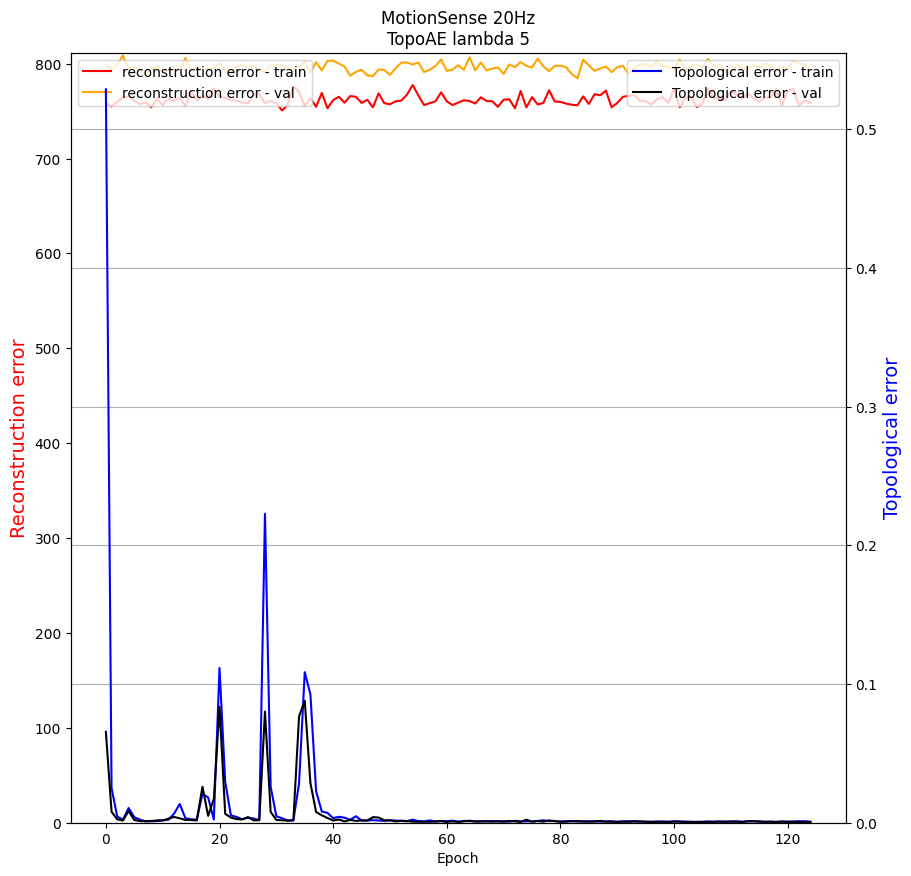

In [31]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [32]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [33]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [34]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7032520325203252,
 'RF-F1': 0.7112574468223778,
 'SVC-ACC': 0.5772357723577236,
 'SVC-F1': 0.6456845652645861,
 'KNN-ACC': 0.6585365853658537,
 'KNN-F1': 0.6589530575490569}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


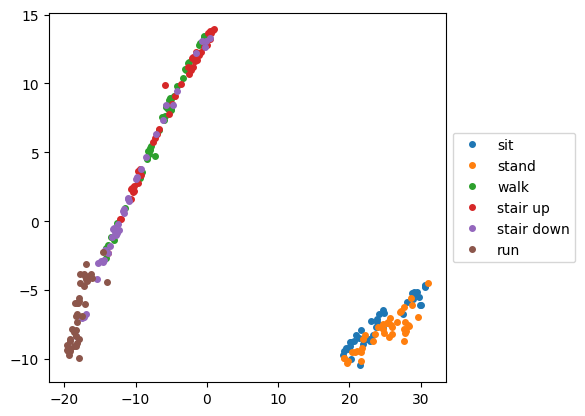

In [35]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [36]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:792.0576, Loss-ae:791.5413, Loss-topo:0.0516
Epoch:2, P:None, Loss:792.4102, Loss-ae:792.3373, Loss-topo:0.0073
Epoch:3, P:None, Loss:789.0805, Loss-ae:789.0304, Loss-topo:0.0050
Epoch:4, P:None, Loss:800.5088, Loss-ae:800.4844, Loss-topo:0.0024
Epoch:5, P:None, Loss:790.8032, Loss-ae:790.4682, Loss-topo:0.0335
Epoch:6, P:None, Loss:797.6302, Loss-ae:797.3823, Loss-topo:0.0248
Epoch:7, P:None, Loss:805.4080, Loss-ae:805.3211, Loss-topo:0.0087
Epoch:8, P:None, Loss:795.7516, Loss-ae:795.7302, Loss-topo:0.0021
Epoch:9, P:None, Loss:795.8991, Loss-ae:795.8854, Loss-topo:0.0014
Epoch:10, P:None, Loss:795.0019, Loss-ae:794.9842, Loss-topo:0.0018
Epoch:11, P:None, Loss:787.0785, Loss-ae:787.0655, Loss-topo:0.0013
Epoch:12, P:None, Loss:795.9938, Loss-ae:795.9814, Loss-topo:0.0012
Epoch:13, P:None, Loss:800.3906, Loss-ae:800.3791, Loss-topo:0.0012
Epoch:14, P:None, Loss:792.7032, Loss-ae:792.2303, Loss-topo:0.0473
Epoch:15, P:None, Loss:805.5899, Loss-ae:805.4483, Loss-t

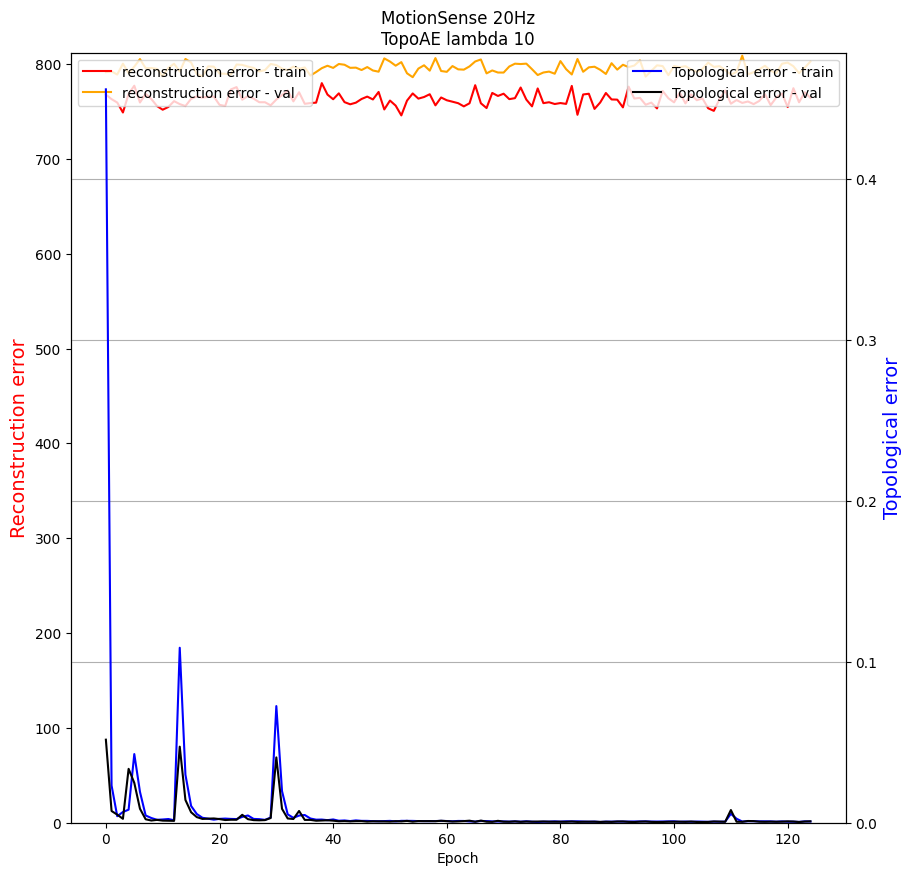

In [37]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [38]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [39]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [40]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7227642276422765,
 'RF-F1': 0.7277922487114828,
 'SVC-ACC': 0.6747967479674797,
 'SVC-F1': 0.6898744255353338,
 'KNN-ACC': 0.6991869918699187,
 'KNN-F1': 0.7029351975992285}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


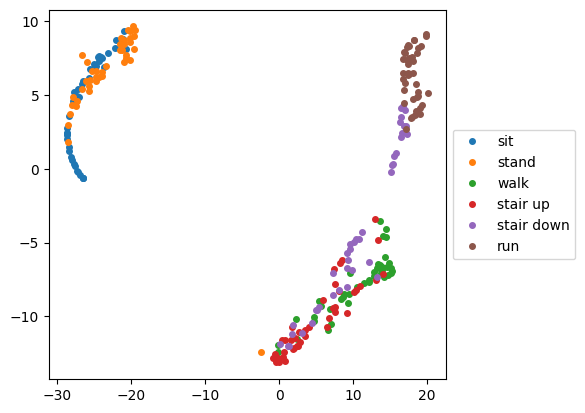

In [41]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [42]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()
/home/darlinne.soto/librep-hiaac/experiments/Topological_ae/KuHar20Hz/../../../librep/transforms/topo_ae.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_tensor = torch.tensor(reshaped_data, device=cuda0).float()


Epoch:1, P:None, Loss:794.6160, Loss-ae:791.2009, Loss-topo:0.0342
Epoch:2, P:None, Loss:792.7174, Loss-ae:792.3371, Loss-topo:0.0038
Epoch:3, P:None, Loss:801.1123, Loss-ae:800.9727, Loss-topo:0.0014
Epoch:4, P:None, Loss:798.6287, Loss-ae:798.5089, Loss-topo:0.0012
Epoch:5, P:None, Loss:798.2241, Loss-ae:798.1659, Loss-topo:0.0006
Epoch:6, P:None, Loss:800.9222, Loss-ae:800.8450, Loss-topo:0.0008
Epoch:7, P:None, Loss:792.5103, Loss-ae:792.4492, Loss-topo:0.0006
Epoch:8, P:None, Loss:787.6207, Loss-ae:787.5643, Loss-topo:0.0006
Epoch:9, P:None, Loss:790.9665, Loss-ae:790.8912, Loss-topo:0.0008
Epoch:10, P:None, Loss:799.5810, Loss-ae:799.5060, Loss-topo:0.0008
Epoch:11, P:None, Loss:792.5523, Loss-ae:792.4634, Loss-topo:0.0009
Epoch:12, P:None, Loss:797.7761, Loss-ae:797.7172, Loss-topo:0.0006
Epoch:13, P:None, Loss:795.7235, Loss-ae:795.6485, Loss-topo:0.0008
Epoch:14, P:None, Loss:799.5522, Loss-ae:799.4715, Loss-topo:0.0008
Epoch:15, P:None, Loss:794.2246, Loss-ae:794.1269, Loss-t

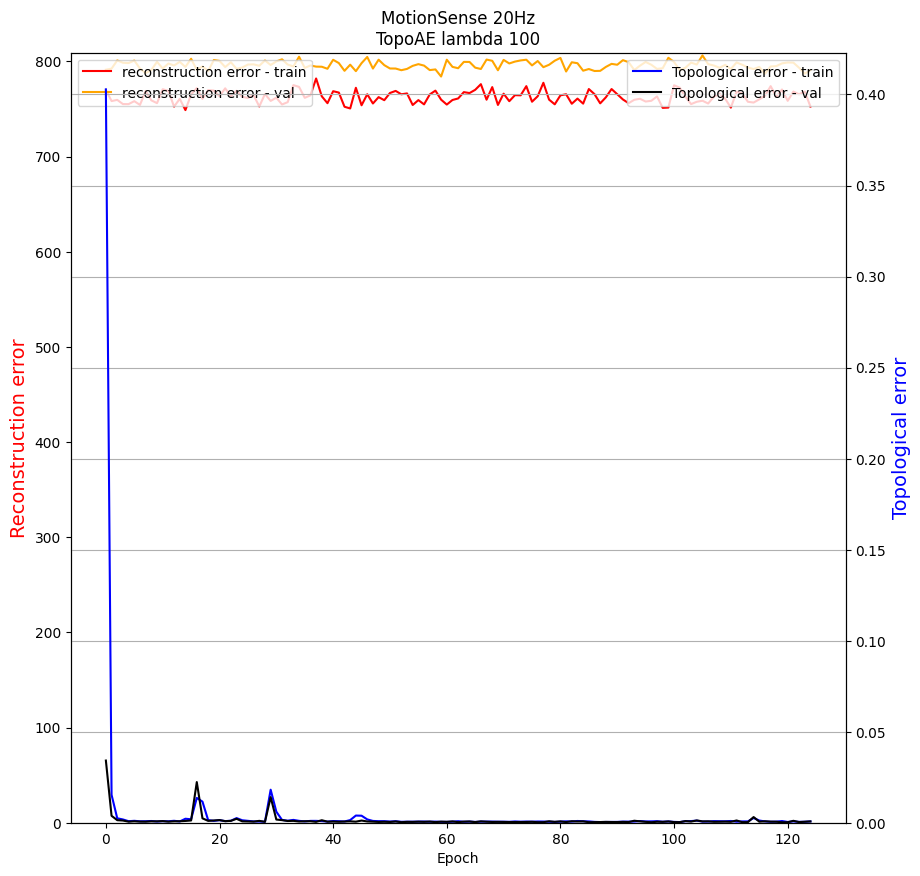

In [43]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [44]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [45]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [46]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.6845528455284553,
 'RF-F1': 0.693640913613067,
 'SVC-ACC': 0.6056910569105691,
 'SVC-F1': 0.6672702412760572,
 'KNN-ACC': 0.6219512195121951,
 'KNN-F1': 0.6236775011169577}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


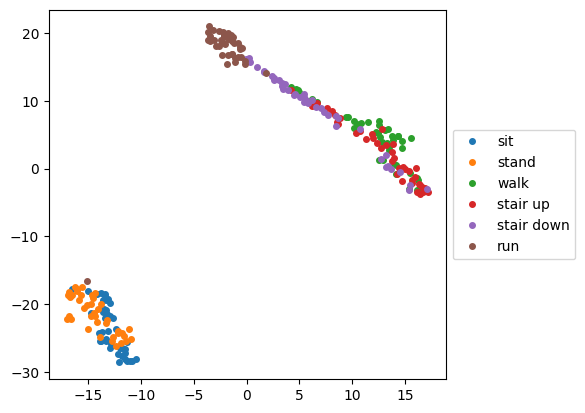

In [47]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [48]:
# Reducing with Convolutional Topological Autoencoders

In [49]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [50]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [51]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [52]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [53]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result